# Linear Regression and Binary Classification, a Friendly Introduction

# Assumptions and Disclaimers
This blogpost assumes that you have already completed the following tutorials from Amazon SageMaker docuemntation:
- [Setting up](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-set-up.html)
- [Create am Amazon SageMaker Notebook Instance](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-setup-working-env.html)
- I have included 'sagemaker' in the name of my S3 bucket, "cyrusmv-sagemaker-demos' and have chosen to let any SageMaker notebook instance to access any S3 bucket with the term 'sagemaker' included in the name. This is however is not a recommended security option for production and is only useful for simplifying the flow of the blog.
- In this blog I am using [Titanic dataset from Kaggle](https://www.kaggle.com/c/titanic/data). I have put the dataset in an S3 bucket. You should also download the dataset and upload the data onto S3 otherwide you shall receive errors.



# Introduction
Surprisingly, many problems in the real-world can be approximated to a linear problem, meaning that a linear polynomial can provide a good output approximation to an n-dimensional input vector. Linear regression is perhaps the most applied and simplest of all machine learning models.

With this in mind, we have implemented a scalable linear regression model as a part of Amazon Algorithms that can be used in Amazon SageMaker.

In first part of this post I intend to provide an easy and intuitive introduction to linear regression as well as providing references to implement your own linear regression, both from scratch and using MXNet and Gluon.

In part 2, Getting Hands-On with Linear Learner and Amazon SageMaker, I use the Visa Credit Card Fraud dataset from Kaggle, pre-process the data, and use Amazon LinearLearner to predict fraudulent transactions. During the course of Part 2 of the blog I walk through an entire processes of data pre-processing, training, and deployment of a model as a live endpoint. 

In part 2 of the blog, we observe that using default values of LinearLeaner yields an impressive precision of near certainty. However, the recall on the fraudulent transactions is 80%. In part 3 of the blog, Excel in tuning models using Amazon LinearLearner Algorithm, I attempt to fine-tune the model on the Visa dataset to see whether or not the recall could be improved. 


# An Introduction to Linear Regression
## The Theory:
Let us consider a dataset composed of discrete values scattered around in a way that a straight line can pass through them, meaning most of the data are within a certain distance from the line.

Remembering from high-school math, we know that in a two-dimensional space a straight line can be represented a function, formalized as:
$$f:\mathcal{D} \rightarrow \mathcal{R}$$
$$y = f(x) = ax + b$$
Now if $\mathcal{D}=\left\{0, 2, 3, ..., 49\right\}$, then for $a=2$ and $b=1$, $\mathcal{R}$ is a set including all positive odd numbers that are less than $100$.

Below we create such data and plot the function.

In [1]:
import numpy as np #a library for array operations
import matplotlib.pyplot as plt #Python 2D plotting library
import random as rnd
import seaborn as sns           #Plotting library based on matplotlib that can take pandas.DataFrame inputs
import pandas as pd             #tabular data structure with SQL-like function support
import boto3                    #Python SDK for AWS services

In [2]:
range_start = 0
range_end = 49

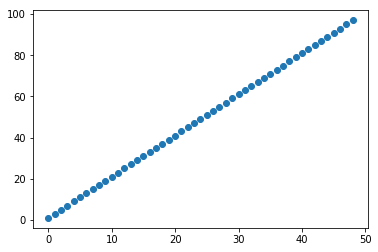

In [3]:
d = np.arange(range_start, range_end)
r = list(map(lambda x: 2 * x + 1, d)) #function y = 2x+1 for domain d, returning the range as a list
plt.scatter(d, r, )
plt.show()

**Adding Noise**
The problem is that the data in real life is noisy and almost never follows a perfect line. In many cases, however the distribution of data permits us to approximate the data to a line that represents the distribution with some error. Below we synthesize a dataset based on the same function, except that, the domain will be a random normal distribution with some random noise between 0 and 1.

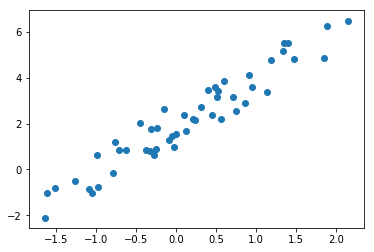

In [4]:
noise_factor = 2
rnd.seed(42)
np.random.seed(13)
d = np.random.normal(loc=range_start, scale=1, size=range_end + 1)
r = list(map(lambda x: 2 * x + 1 + rnd.random()* noise_factor, d))
plt.scatter(d, r, )
plt.show()

It is noticeable that a straight line can provide a good approximation for the data distribution. in a multi-dimensional world, where the function variable is a vector such as <age, income, postal district, ...>, our function would be:
$$f:{V} \subseteq \mathbb{R}^n  \rightarrow \mathcal{R} \subseteq \mathbb{R}
\\ 
y = f(V) = V.W + b
$$
in which V is the input feature vector, w is a parameter or weight vector and b is bias. The task of linear regression is to find optimal w and b in order to approximate the data to a line.

In the graph below we are using seaborn library in order to find the optimal line that approximates our distribution (the green line).


Suppose we have a 4D input space $$V=\{inv_1=gender, v_2=age, v_3=education, v_4=postal\_district\}$$ and would like to predict income. Since the range of the function is $\mathbb {R}$ and $V$ has a dimention of $1 \times 4$, we should find $W_{4 \times 1}$ and scalar $d$ to solve the linear regression problem.

$$
f: \mathbb{R^4} \rightarrow \mathbb{R} \\ 
f(V) = \left[\begin{array}{cc} v_1 & v_2 & v_3 & v_4 \end{array}\right]_{1 \times 4} \ 
\left[\begin{array}{cc} w_1\\ w_2\\ w_3\\ w_4 \end{array}\right]_{4 \times 1} \
+ d \ \epsilon \ \mathbb {R}  = y \ \epsilon \ \mathbb {R}
$$

In machine learning the input space is always multi-dimensional, but in our examples and plots we have used 1D synthetic data in order to simplify the presentation.

*Challenge: You can change shape and noise of the data and check the results.*


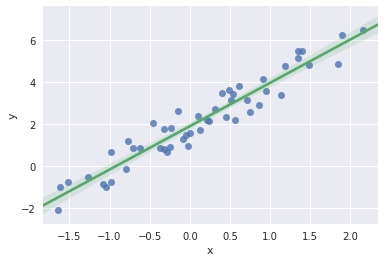

In [5]:
noisy_data = pd.DataFrame(np.column_stack((d, r)), columns=['x', 'y'])
sns.set(color_codes=True)
sns.regplot('x', 'y', data=noisy_data, line_kws={'color': 'g'}, scatter_kws={'color':'b'})
plt.show()


In [6]:
print("in the perfect world f(d[5]) = f({}) = {}".format(d[5], 2*d[5]+1))
print("in the reality f(d[5]) = f({}) = {}".format(d[5], r[5]))


in the perfect world f(d[5]) = f(0.5323378882945463) = 2.064675776589093
in the reality f(d[5]) = f(0.5323378882945463) = 3.4180747514349155


## Model Error
In the perfect world f(d[5]) = f(0.5323378882945463) = __2.064675776589093__. 
In the reality f(d[5]) = f(0.5323378882945463) = **3.4180747514349155**.

The first number is passing a number to our linear function, calculating the results based on its formula and printing the results. The second is the actual number. There is a distance between the two numbers. The delta between the two numbers is resulted from error in the model. As we approximated out data points to a line, we introduced a delta between actual position of a point and its projected position on the regression line.

This might look like loss of accuracy, but in fact this approximation is the source of generalization power of machine learning for as long as the error is within acceptable threshold.

There are many methods of calculating error. One of the most common for linear regression is MSE or Mean Squared Error.

Mean Squared Error is the average of Euclidean distance between observed values (values collected from real-world) and projected valued from our regression line.


![Model Error or Loss](https://github.com/zackchase/mxnet-the-straight-dope/raw/dc1822005027d63eb9a20cde1a6276c7714050f4/img/linear-regression.png)

*reference: https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter02_supervised-learning/linear-regression-scratch.ipynb*

We can observe in thed below diagram that every point has a distance to the line. MSE is averaring distances of all the datapoint to our regression lin or formally:

Assume that $N$ is the number of data points and $d_i$ is the euclidean distance of data point $p_i$ to the regression line $l$, then: 
$$
MSE = \frac{1}{n}\sum_{i=1}^{N}d_i
$$
if $y_i$ is the the observed value for a particular input $x_i$ and $\hat{y_i}$ is the predicted value, then their euclidean distance is calculated as:

$$
d^2 = (y_i - \hat{y_i})^2 \\
\therefore \\
\mathcal{L} = MSE = \frac{1}{n}\sum_{i=1}^{N}{(y_i - \hat{y_i})^2}
$$

RMSE is a varint of MSE and is very popular for calculation of model error:
$$
\mathcal{L} = RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{N}{(y_i - \hat{y_i})^2}}
$$

## An Example
A classic example of linear regression is survival score for a passenger in Titanic's infamous maiden voyage. Titanic dataset in Kaggle has captured this data.for more information on the dataset please chekout [!this link](https://www.kaggle.com/c/titanic). 

In Titanic dataset there are several inputs such as class, ticket price, gender, age, and others. We would like to project a probability for survival of a passenger, given features representeting the passenger.

are several inputs such as class, ticket price, gender, age, and others. We would like to project a probability for survival of a passenger, given features representing the passenger.

One final twist is that we would like to make a binary prediction as to whether or not a passenger will survive. Regression models always make a real-valued prediction. If that value is bounded between 0 and 1, then that would be a probability value from a distribution. We can then use a threshold or project the output value to a binary projection. 

For instance, we can set the threshold to 0.5, anything above indicating a passenger has survived, and below indicates otherwise.

Since models do approximate, they necessarily produce errors. A model can predict false positives, true positive, false negative, and true negative. 

-	A false positive prediction in our example is when the model predicts survival when the person has not survived.

-	A true positive prediction in our example is when the model predicts survival correctly.

-	A false negative prediction in our example is when the model predicts not-survived while the person has survived.

-	A true negative prediction in out example is when the model correctly predicts that a passenger has not survived.

Based on what is important for us we might want to adjust the threshold in order to reduce false positives or false negatives at the expense of a model’s total precision or accuracy.

Let us take a look at another example. In the case of a cancer diagnosis algorithm, we would like to have no-false negatives, if at all possible. It is always better to flag a healthy patient as suspect and perform further tests, as opposed to letting a patient with cancer leaves the clinic unchecked.

*Note that I have already uploaded titaic train.csv from the kaggle website onto an S3 bucket.*


In [7]:
#Downloading data files from S3 to the notebook instance
bucket = 'cyrusmv-sagemaker-demos' 
protocol = 's3://'

#titanic dataset
titanic_train_prefix = 'titanic-kaggle/train.csv'
titanic_train_datafile = 'data/titanic_train.csv'


#Downloading the file to a local folder
client = boto3.client('s3')
with open(titanic_train_datafile, 'wb') as f:
    client.download_fileobj(bucket, titanic_train_prefix, f)
    
    


In [8]:
#Inspecting Data
df = pd.read_csv(titanic_train_datafile)
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


All columns, other than *survived* are called *features*. The goal of regression task is to predicta *target* based on learning patterns from *features*. Column *survived* is our *target*.
The regression task predicts a probability of survival. As mentioned before in a binary prediction task, we use a threshold function to make a binary decision based on a probability score. For example, using a step function to set the threshold.

$$ 
f(x) = \begin{cases} 
      1 & x\geqq 0.5, \\
      0 & x< 0.5 
   \end{cases}
$$
We can indeed change the threshold in order to tune the model for precision or recall as mentionef before.

__***Note:***__ for logistic regression or Binary Classification Binary Cross Entropy Loss is being used. A binary decision could also be solved a classification problems with two classes, and apply SoftMaxCrossEntropy loss function. This is outside of the scoped of this blog. For more information plase refer to: [logistic regression using gluon](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter02_supervised-learning/logistic-regression-gluon.ipynb)



We shall now depart from the Titanic example, because the data requires pre-processing. Pre-processing of data is a crucial task in developing machine learning models and requires a separate post. We now use the credit card data set from Kaggle, where data is pre-processed, meaning:
- All data is numeric
- All data is factorized, meaning that ranges are transformed to *"one-of-N* form.
- All data is normalized, meaning that the ranges have become comparable.


For more information and learning how to write your own linear regression and binary classification models please refer to:
- [linear regression from scratch](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter02_supervised-learning/linear-regression-scratch.ipynb)
- [linear regression using gluon](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter02_supervised-learning/linear-regression-gluon.ipynb)

for the binary variant or logistic regression please refer to:
- [logistic regression using gluon](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter02_supervised-learning/logistic-regression-gluon.ipynb)


# End of Part 1.
for learning about linear learner pleased read part 2 of this blog